# Use GleasonXAI for single image prediction

1. DATASET_LOCATION needs to be set


2. The label_level1 SoftDiceBalanced models 1, 2, and 3 must be located at: 

[DATASET_LOCATION]/GleasonXAI/GleasonFinal2/label_level1/SoftDiceBalanced-{i}/version_0/checkpoints/best_model.ckpt


## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import hydra
import torch
import omegaconf
import cv2

import torchvision.transforms as tt
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from PIL import Image
from monai.inferers import SlidingWindowInferer
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from pytorch_lightning import Trainer

from src.augmentations import normalize_only_transform
from src.lightning_modul import LitSegmenter
from src.gleason_data import GleasonX
from src.gleason_utils import tissue_filter_image



/home/mittmann/Tools/miniconda3/envs/finalGleasonXAI/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Path Settings

In [3]:
model_paths = [Path(f"GleasonFinal2/label_level1/SoftDiceBalanced-{i}/version_0/checkpoints/best_model.ckpt") for i in [1, 2, 3]]
base_path = Path(os.environ['DATASET_LOCATION']) / "GleasonXAI"
example_img = Path(os.environ['DATASET_LOCATION']) / "GleasonXAI" / "TMA" / "MicronsCalibrated" / "ZT80_38_C_8_9.jpg"

## Load Model

In [4]:
class_number_mapping = {'Benign': 0,
 'variable sized well-formed individual and discrete glands': 1,
 'compressed or angular discrete glands': 2,
 'poorly formed and fused glands': 3,
 'Cribriform glands': 4,
 'Glomeruloid glands': 5,
 'solid groups of tumor cells': 6,
 'single cells': 7,
 'cords': 8,
 'presence of comedonecrosis': 9}

In [5]:
data_color_map = np.array([[1.        , 1.        , 1.        , 1.        ],
       [0.64364475, 0.85614764, 0.61979239, 1.        ],
       [0.24521338, 0.66025375, 0.35695502, 1.        ],
       [0.71618608, 0.83320261, 0.91615532, 1.        ],
       [0.41708574, 0.68063053, 0.83823145, 1.        ],
       [0.17914648, 0.49287197, 0.73542484, 1.        ],
       [0.98823529, 0.72198385, 0.61836217, 1.        ],
       [0.98683583, 0.51657055, 0.39108035, 1.        ],
       [0.95404844, 0.29714725, 0.21453287, 1.        ],
       [0.80604383, 0.10380623, 0.11787774, 1.        ]])

In [6]:
named_classes = ['Benign',
 'variable sized well-formed individual and discrete glands',
 'compressed or angular discrete glands',
 'poorly formed and fused glands',
 'Cribriform glands',
 'Glomeruloid glands',
 'solid groups of tumor cells',
 'single cells',
 'cords',
 'presence of comedonecrosis']

In [7]:
model_config = base_path / "GleasonFinal2"/"label_level1"/"SoftDiceBalanced-1"/"version_0"/"logs"/"config.yaml"
config = omegaconf.OmegaConf.load(model_config)

preds_paths = []
for path in model_paths:
    assert (base_path/path).exists(), f"Could not find {str(base_path/path)}"

TRANSFORM = normalize_only_transform
tissue_mask_kwargs =  {"open": False, "close": False, "flood": False}


In [8]:
device='cpu'
net = hydra.utils.instantiate(config.model, classes=10)

In [9]:
SLIDING_WINDOW_INFERER = SlidingWindowInferer(roi_size=(512, 512), sw_batch_size=1, overlap=0.5, mode="gaussian")

In [10]:
model1 = LitSegmenter.load_from_checkpoint(str(base_path / model_paths[0]), map_location=device)
model2 = LitSegmenter.load_from_checkpoint(str(base_path / model_paths[1]), map_location=device)
model3 = LitSegmenter.load_from_checkpoint(str(base_path / model_paths[2]), map_location=device)

models = [model1, model2, model3]

/home/mittmann/Tools/miniconda3/envs/finalGleasonXAI/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.1.3
/home/mittmann/Tools/miniconda3/envs/finalGleasonXAI/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [11]:
mask_colormap = ListedColormap(np.concatenate([np.array([[0., 0., 0., 1.]]), data_color_map]))#data.colormap.colors]))
no_mask_colormap = ListedColormap(data_color_map)#data.colormap
mask_num_class_to_vis = 11#data.num_classes + 1
num_class_to_vis = 10# data.num_classes

## Generate Output

In [12]:
def generate_model_output(model, img, device="cpu", label_remapping=None, inferer=SLIDING_WINDOW_INFERER, transform=TRANSFORM):
    model.eval()

    img = TRANSFORM(image=img)['image']
    
    if not isinstance(img, torch.Tensor):
        img = tt.functional.to_tensor(img)
    

    if len(img.size()) == 3:
        no_batch_input = True
        img = img.unsqueeze(0)
    else:
        no_batch_input = False

    img = img.to(device)

    with torch.no_grad():
        if inferer is not None:
            out = inferer(img, model)
        else:
            out = model(img)

    # Move back and strip batch_dim
    out = out.cpu()

    if label_remapping is not None:
        out = label_remapping(out)

    if no_batch_input:
        out = out[0, ...]

    return out

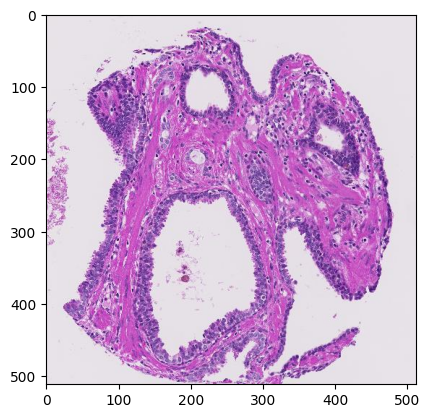

In [13]:
example_img = Image.open(example_img)
example_img = np.array(example_img)

plt.imshow(example_img)

In [14]:
background_mask = ~tissue_filter_image(example_img, size=np.array(example_img.shape[:2])[::-1], **tissue_mask_kwargs)

In [15]:
preds_ensemble = generate_model_output(models[0], example_img, device, None, SLIDING_WINDOW_INFERER, TRANSFORM)
single_preds = [torch.detach(preds_ensemble).clone()]

for model in models[1:]:
    out = generate_model_output(model, example_img, device, None, SLIDING_WINDOW_INFERER, TRANSFORM)
    preds_ensemble += out
    single_preds.append(out.clone())

preds_ensemble = torch.nn.functional.softmax(preds_ensemble, dim=0)
np_seg = np.array(preds_ensemble.argmax(dim=0)).astype(np.uint8)

np_single_preds = [np.array(s_pred.argmax(dim=0)).astype(np.uint8) for s_pred in single_preds]

#plt.imshow(np_seg, cmap=no_mask_colormap, interpolation_stage='rgba', vmax=num_class_to_vis)
#plt.imshow(np_single_preds[0], cmap=no_mask_colormap, interpolation_stage='rgba', vmax=num_class_to_vis)

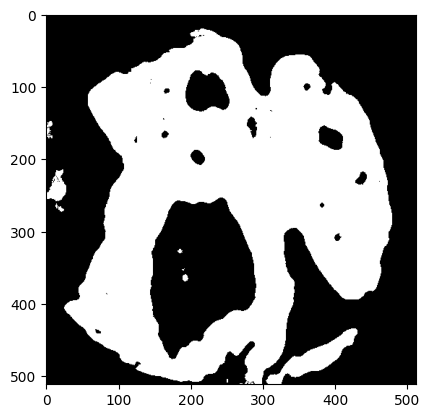

In [16]:
mask_np_seg = np_seg + 1
mask_np_seg[background_mask.astype(bool)] = 0
plt.imshow(mask_np_seg, cmap=mask_colormap, interpolation_stage='rgba', vmax=mask_num_class_to_vis)

In [17]:
for i in range(len(np_single_preds)):
    np_single_preds[i] = np_single_preds[i] + 1
    np_single_preds[i][background_mask.astype(bool)] = 0

<Figure size 640x480 with 0 Axes>

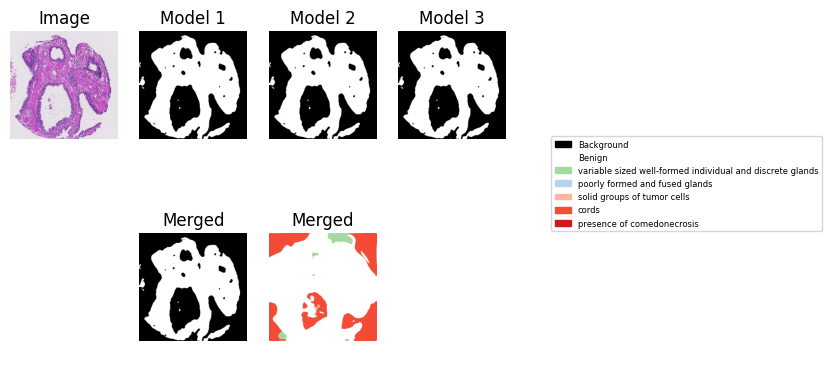

In [18]:
plt.figure()
fig, ax = plt.subplots(2,4) 

ax[0][0].imshow(example_img)
ax[0][0].set_title('Image')
ax[0][1].imshow(np_single_preds[0], cmap=mask_colormap, interpolation_stage='rgba', vmax=mask_num_class_to_vis)
ax[0][1].set_title('Model 1')
ax[0][2].imshow(np_single_preds[1], cmap=mask_colormap, interpolation_stage='rgba', vmax=mask_num_class_to_vis)
ax[0][2].set_title('Model 2')
ax[0][3].imshow(np_single_preds[2], cmap=mask_colormap, interpolation_stage='rgba', vmax=mask_num_class_to_vis)
ax[0][3].set_title('Model 3')
ax[1][1].imshow(mask_np_seg, cmap=mask_colormap, interpolation_stage='rgba', vmax=mask_num_class_to_vis)
ax[1][1].set_title('Merged')
ax[1][2].imshow(np_seg, cmap=no_mask_colormap, interpolation_stage='rgba', vmax=num_class_to_vis)
ax[1][2].set_title('Merged')

for i in range(2):
    for j in range(4):
        ax[i][j].axis('off')

encountered_classes = set(np.unique(np_seg))
legend_handels = [mpatches.Patch(color=np.array([0., 0., 0., 1.]), label=f"Background")]
legend_handels += [mpatches.Patch(color=no_mask_colormap(class_number_mapping[cls]), label=cls if len(cls) < 60 else cls[:60]+"...")
                               for cls in named_classes if class_number_mapping[cls] in encountered_classes]
fig.legend(handles=legend_handels, loc="outside right", fontsize=6, bbox_to_anchor=(1.4, 0.5))

plt.show()